# Ennustemalli keräilyriveistä

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from datetime import date

In [2]:
df_raw = pd.read_excel('keräilyhistoria.xlsx')

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Vuosi     1029 non-null   int64         
 1   kk        1029 non-null   int64         
 2   vko       1029 non-null   int64         
 3   pvm       1029 non-null   datetime64[ns]
 4   päivä     1029 non-null   object        
 5   100       743 non-null    float64       
 6   200       739 non-null    float64       
 7   300       738 non-null    float64       
 8   Yhteensä  1029 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(1)
memory usage: 72.5+ KB


Lots of Nulls due to weekends, fill with zeros

In [4]:
df_raw.fillna(0, inplace=True)

In [5]:
df_raw.tail()

,Vuosi,kk,vko,pvm,päivä,100,200,300,Yhteensä
1024,2021,10,42,2021-10-22,Pe,2560.0,1006.0,1274.0,4840
1025,2021,10,42,2021-10-23,La,0.0,0.0,0.0,0
1026,2021,10,42,2021-10-24,Su,0.0,0.0,0.0,0
1027,2021,10,43,2021-10-25,Ma,2941.0,1411.0,1618.0,5970
1028,2021,10,43,2021-10-26,Ti,3100.0,1435.0,1422.0,5957


In [6]:
df_all = df_raw[['pvm','Yhteensä']].rename(columns={'pvm':'ds','Yhteensä':'y'})

In [7]:
df_all.head()

,ds,y
0,2019-01-02,5203
1,2019-01-03,4828
2,2019-01-04,4503
3,2019-01-05,0
4,2019-01-06,0


<AxesSubplot:xlabel='ds', ylabel='y'>

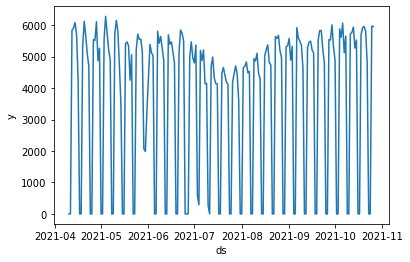

In [8]:
sns.lineplot(x='ds',y='y', data = df_all.tail(200))

### Create holiday calendar for Prophet

In [9]:
fin_holidays = pd.DataFrame(holidays.FIN(years=([2019,2020,2021,2022])).items()).rename(columns={0:'ds', 1:'holiday'})

In [10]:
fin_holidays.head()

,ds,holiday
0,2019-01-01,Uudenvuodenpäivä
1,2019-01-06,Loppiainen
2,2019-04-19,Pitkäperjantai
3,2019-04-21,Pääsiäispäivä
4,2019-04-22,2. pääsiäispäivä


### Ennuste - Kaikki rivit

In [11]:
m = Prophet(holidays = fin_holidays)
m.fit(df_all)
future = m.make_future_dataframe(periods=365)

### forecast but not for weekends
forecast = m.predict(future[future['ds'].dt.weekday < 5])


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


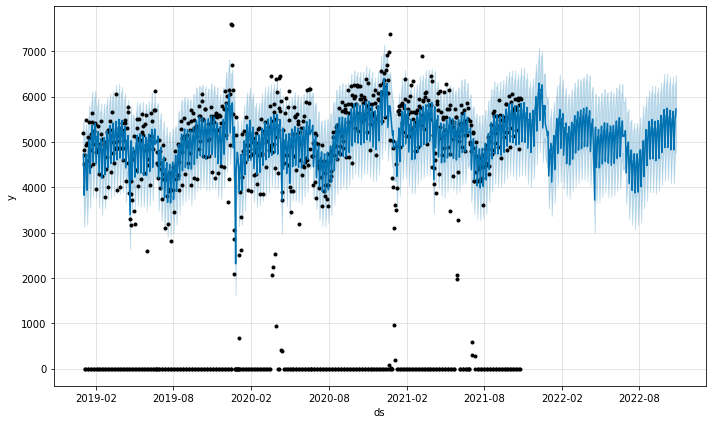

In [12]:
forecast_plot_prophet = m.plot((forecast[forecast['yhat'] > 2000]))

In [13]:
df_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df_forecast_future = df_forecast[df_forecast['ds'] > '2021-10-31'] 
df_forecast_future_2021 = df_forecast[(df_forecast['ds'] > '2021-10-31') & (df_forecast['ds'] < '2021-12-31')] 

In [14]:
df_forecast_future.head(2)

,ds,yhat,yhat_lower,yhat_upper
738,2021-11-01,5715.094828,5021.482791,6457.000864
739,2021-11-02,5711.021370,5043.192838,6433.172888


### Ennuste kaikista riveistä paremmin visualisoituna

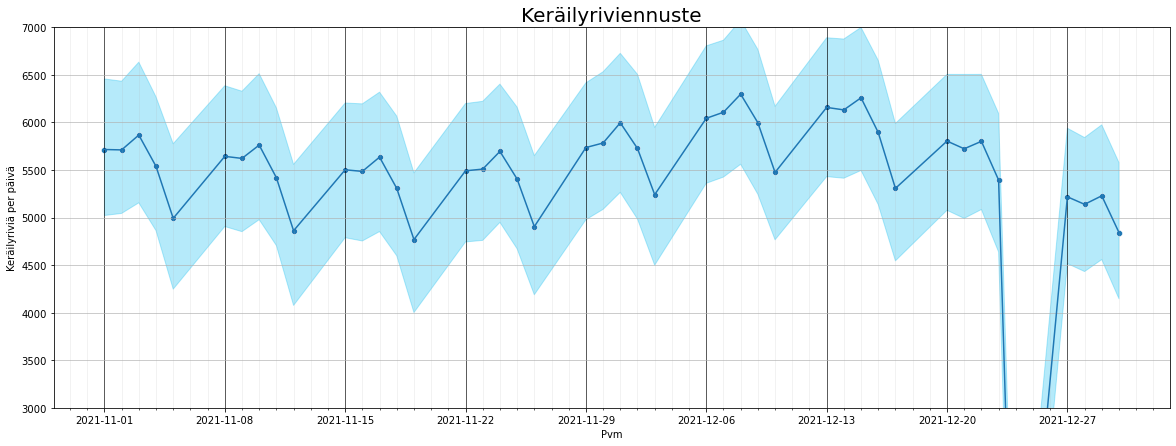

In [15]:
import matplotlib.dates as dt
import matplotlib.ticker as ticker


fig, ax = plt.subplots(figsize = (20,7))

ax.fill_between(df_forecast_future_2021['ds'], df_forecast_future_2021['yhat_lower'], df_forecast_future_2021['yhat_upper'], color='#0abbef', alpha=0.3)
sns.lineplot(x='ds', y='yhat',data = df_forecast_future_2021, ax=ax)
sns.scatterplot(x='ds', y='yhat',data = df_forecast_future_2021, ax=ax)

ax.set_ylabel('Keräilyriviä per päivä')
ax.set_xlabel('Pvm')

ax.set_ylim(3000,7000)
ax.set_xticks(df_forecast_future_2021[df_forecast_future_2021['ds'].dt.weekday == 0]['ds'])
ax.xaxis.set_minor_locator(dt.DayLocator())
ax.grid(b=True, which='minor', alpha=0.2)
ax.grid(b=True, axis='y', which='major', alpha=0.8)
ax.grid(b=True, axis='x', which='major', alpha=0.8, color='black')
ax.set_title('Keräilyriviennuste', fontsize=20);
plt.savefig('Keräilyriviennuste_versio_1')


### Mallin tarkkuus

In [16]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='365 days', period='180 days', horizon = '90 days')


INFO:prophet:Making 4 forecasts with cutoffs between 2020-02-04 00:00:00 and 2021-07-28 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

INFO:prophet:Skipping MAPE because y close to 0


In [18]:
df_p.head()

,horizon,mse,rmse,mae,mdape,smape,coverage
0,9 days,148852.034775,385.813471,332.158728,0.083716,0.605898,0.972222
1,10 days,144434.398812,380.045259,321.377246,0.090293,0.608233,0.972222
2,11 days,146419.590543,382.648129,311.845716,0.096641,0.659323,0.972222
3,12 days,175461.125202,418.880801,349.612514,0.113921,0.663029,0.972222
4,13 days,204054.110071,451.723489,365.748598,0.113921,0.613934,0.944444


### Mean Averate Error 

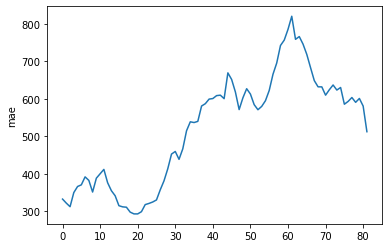

In [21]:
sns.lineplot(x=df_p.index, y='mae', data=df_p);

##### Mallin tarkkuus kohtullisella tasolla noin kuukauden, eli keskimääräinen virhe alle 10% kokonaisrivimäärästä

### Ennuste - Varastoalueittain 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


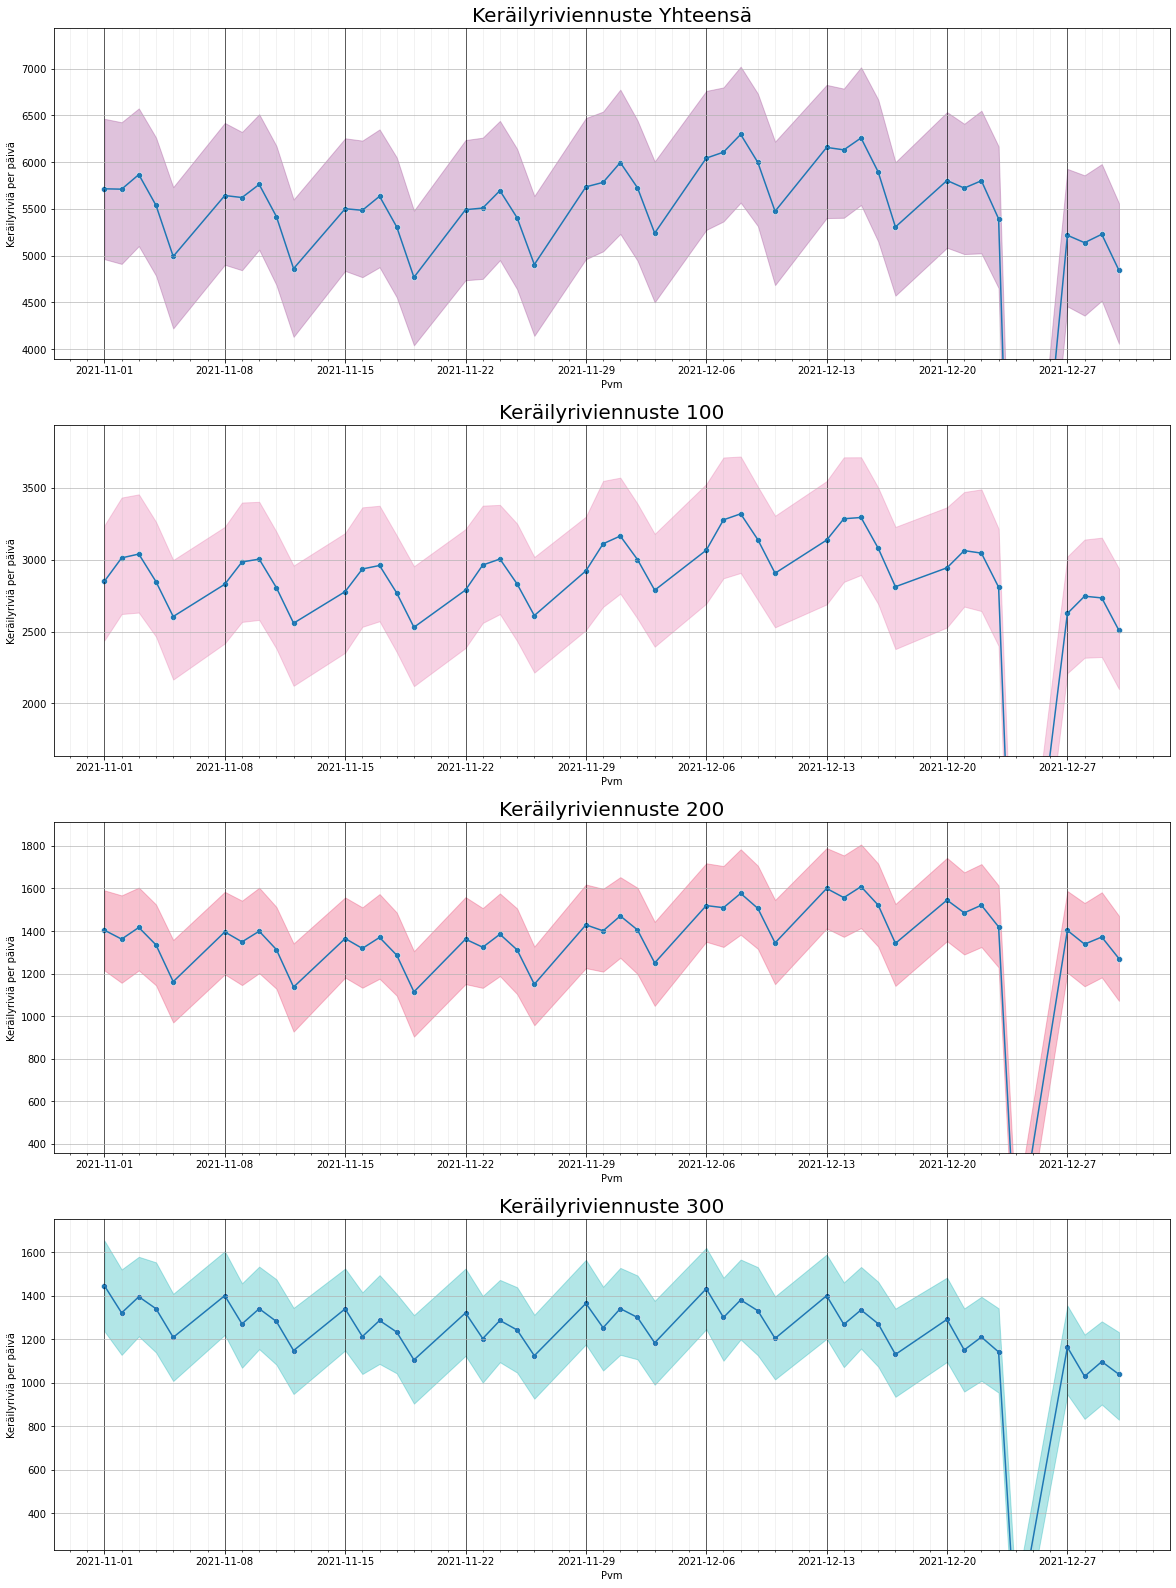

In [22]:
alueet = ['Yhteensä',100,200,300]
värit = ['#96368b','#e56da6','#e83363','#00adb1']
import matplotlib.dates as dt
fig, axes = plt.subplots(4,1,figsize = (20,4*7))


for i, alue in enumerate(alueet):

    df_alue = df_raw[['pvm',alue]].rename(columns={'pvm':'ds',alue:'y'})
    
    m = Prophet(holidays = fin_holidays)
    m.fit(df_alue)
    future = m.make_future_dataframe(periods=365)

    ### forecast but not for weekends
    forecast = m.predict(future[future['ds'].dt.weekday < 5])
    
    df_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    df_forecast_future_2021 = df_forecast[(df_forecast['ds'] > '2021-10-31') & (df_forecast['ds'] < '2021-12-31')] 
    
    

    axes[i].fill_between(df_forecast_future_2021['ds'], df_forecast_future_2021['yhat_lower'], df_forecast_future_2021['yhat_upper'], color=värit[i], alpha=0.3)
    sns.lineplot(x='ds', y='yhat',data = df_forecast_future_2021, ax=axes[i])
    sns.scatterplot(x='ds', y='yhat',data = df_forecast_future_2021, ax=axes[i])

    axes[i].set_ylabel('Keräilyriviä per päivä')
    axes[i].set_xlabel('Pvm')

    axes[i].set_ylim(bottom=df_forecast_future_2021['yhat_lower'].mean()-800)
    axes[i].set_xticks(df_forecast_future_2021[df_forecast_future_2021['ds'].dt.weekday == 0]['ds'])
    axes[i].xaxis.set_minor_locator(dt.DayLocator())
    axes[i].grid(b=True, which='minor', alpha=0.2)
    axes[i].grid(b=True, axis='y', which='major', alpha=0.8)
    axes[i].grid(b=True, axis='x', which='major', alpha=0.8, color='black')
    axes[i].set_title('Keräilyriviennuste ' + str(alue), fontsize=20);
    plt.savefig('Keräilyriviennuste_2021')